# 프로젝트 목표
1. 패스트캠퍼스 구매내역 분석을 통한 마케팅 전략 제안
   - 데이터로 부터 인기코스, 환불코스, 고객별/코스별 구매패턴 등 거래 현황을 파악한다.
   - 매출 기대 상품, 구매전환율 상승 요소 등을 포함하여 마케팅 전략을 제안한다.

# 해야 할 일
 1. 데이터 Cleansing
 2. 데이터셋 목적별 분리
 3. 시각화를 통한 현황 분석 
    - 시계열에 따른 매출 추이 분석
    - 구매빈도 등 행동패턴 분석
    - 인기코스, 포맷, 카테고리 분석
    - 할인쿠폰 제공이 매출에 미치는 상관관계 히트맵 분석

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

COLORS = sns.color_palette(palette='magma')

In [2]:
# !pip install plotly chart_studio --upgrade
# !pip install cufflinks --upgrade

In [3]:
# iplot() 사용하려고 라이브러리 임포트

import chart_studio.plotly as py
import cufflinks as cf
cf.go_offline(connected = True)

In [4]:
# 저장해둔 cleansing 데이터셋을 불러온다. 로드 후, 컬럼삭제(저장 시 생긴 Unname  :0 컬럼), 타입캐스팅

def restore_dataset():
    df = pd.read_csv('2022.07.03_clean_transactions.csv')
    df = df.drop(columns='Unnamed: 0')
    df['completed_at'] = pd.to_datetime(df['completed_at'], infer_datetime_format=True)
    df['marketing_start_at'] = pd.to_datetime(df['marketing_start_at'], infer_datetime_format=True)
    return df

# 분석 목적에 따라 cleansing data 분리
- [x] 결제완료, 환불완료 데이터 --> data1으로 분리 저장
- [x] 주문 취소/완료, 결제취소 데이터 --> data2로 분리 저장
- [x] 환불완료 데이터 --> data3으로 분리 저장
- [x] 결제대기 상태 데이터 --> data4로 분리 저장

In [5]:
df = restore_dataset()

## 결제 및 환불완료 --> data1으로 저장

In [6]:
# 결제완료, 환불완료 데이터 --> data1으로 분리 저장

data1 = df[((df['type'] == 'PAYMENT') & (df['state'] == 'COMPLETED')) | ((df['type'] == 'REFUND') & (df['state'] == 'COMPLETED'))]
data1.type.unique(), data1.state.unique()
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51990 entries, 2 to 100462
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      51990 non-null  int64         
 1   customer_id             51990 non-null  int64         
 2   course_id               49836 non-null  float64       
 3   type                    51990 non-null  object        
 4   state                   51990 non-null  object        
 5   course_title            51990 non-null  object        
 6   category_title          51987 non-null  object        
 7   format                  51990 non-null  object        
 8   completed_at            51990 non-null  datetime64[ns]
 9   transaction_amount      51990 non-null  int64         
 10  coupon_title            20237 non-null  object        
 11  coupon_discount_amount  51990 non-null  float64       
 12  sale_price              51990 non-null  int64

## 주문 취소/완료, 결제 취소 --> data2로 저장

In [7]:
# 주문 취소/완료, 결제취소 데이터 --> data2로 분리 저장

data2 = df[((df['type'] == 'PAYMENT') & (df['state'] == 'CANCELLED')) | (df['type'] == 'ORDER')]
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47315 entries, 0 to 100461
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      47315 non-null  int64         
 1   customer_id             47315 non-null  int64         
 2   course_id               44368 non-null  float64       
 3   type                    47315 non-null  object        
 4   state                   47315 non-null  object        
 5   course_title            47315 non-null  object        
 6   category_title          47310 non-null  object        
 7   format                  47315 non-null  object        
 8   completed_at            47315 non-null  datetime64[ns]
 9   transaction_amount      47315 non-null  int64         
 10  coupon_title            7589 non-null   object        
 11  coupon_discount_amount  47315 non-null  float64       
 12  sale_price              47315 non-null  int64

## 환불완료 --> data3으로 저장

In [8]:
# 환불완료 데이터 --> data3으로 분리 저장

data3 = df[(df['type'] == 'REFUND') & (df['state'] == 'COMPLETED')]
data3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3809 entries, 631 to 100295
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      3809 non-null   int64         
 1   customer_id             3809 non-null   int64         
 2   course_id               3634 non-null   float64       
 3   type                    3809 non-null   object        
 4   state                   3809 non-null   object        
 5   course_title            3809 non-null   object        
 6   category_title          3808 non-null   object        
 7   format                  3809 non-null   object        
 8   completed_at            3809 non-null   datetime64[ns]
 9   transaction_amount      3809 non-null   int64         
 10  coupon_title            0 non-null      object        
 11  coupon_discount_amount  3809 non-null   float64       
 12  sale_price              3809 non-null   int6

## 결제 대기상태 --> data4로 저장

In [9]:
# 결제대기 상태 데이터 --> data4로 분리 저장

data4 = df[(df['type'] == 'PAYMENT') & (df['state'] == 'PENDING')]
data4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1144 entries, 50 to 100321
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      1144 non-null   int64         
 1   customer_id             1144 non-null   int64         
 2   course_id               1065 non-null   float64       
 3   type                    1144 non-null   object        
 4   state                   1144 non-null   object        
 5   course_title            1144 non-null   object        
 6   category_title          1144 non-null   object        
 7   format                  1144 non-null   object        
 8   completed_at            1144 non-null   datetime64[ns]
 9   transaction_amount      1144 non-null   int64         
 10  coupon_title            406 non-null    object        
 11  coupon_discount_amount  1144 non-null   float64       
 12  sale_price              1144 non-null   int64

# 시각화를 통한 현황 분석
- 시계열에 따른 매출 추이 분석
- 구매빈도 등 행동패턴 분석
- 인기코스, 포맷, 카테고리 분석
- 할인쿠폰 제공이 매출에 미치는 상관관계 히트맵 분석

## 매출 추이 시계열 분석
1. 전체 매출 분석
- [X] 전체 매출 추이 (월별)
- [X] B2C, B2B, B2G 매출 비교 (월별)
2. B2C 매출 분석
- [x] B2C 매출 추이(일별)
- [ ] B2C format별 Daily / Monthly 매출 플롯 (범례 : format)
- [ ] B2C category_title 별 Daily / Monthly 매출 플롯 (범례 : category_title)
- [ ] B2C 각 카테고리의 Monthly 주문완료율, 구매전환율, 환불율

In [10]:
# month 추출 함수
def extract_month(date):
    month = str(date.month)
    if date.month < 10:
        month = '0' + month
    return str(date.year) + month

In [11]:
def plot_bar(df, title, xlabel, ylabel, color=COLORS, figsize=(20, 10)):
    sns.set_style('whitegrid')
    plt.rcParams['font.family'] = 'AppleGothic' # 한글폰트 : 나눔고딕 설정
    plot = df.plot(kind='bar', color=COLORS, figsize=(20, 10))
    plot.set_title(title, fontsize=16)
    plot.set_xlabel(xlabel, fontsize=13)
    plot.set_ylabel(ylabel, fontsize=13)
    plot.set_xticklabels(labels=df.index, rotation=90)


### 전체 매출 분석
#### 전체 매출 추이

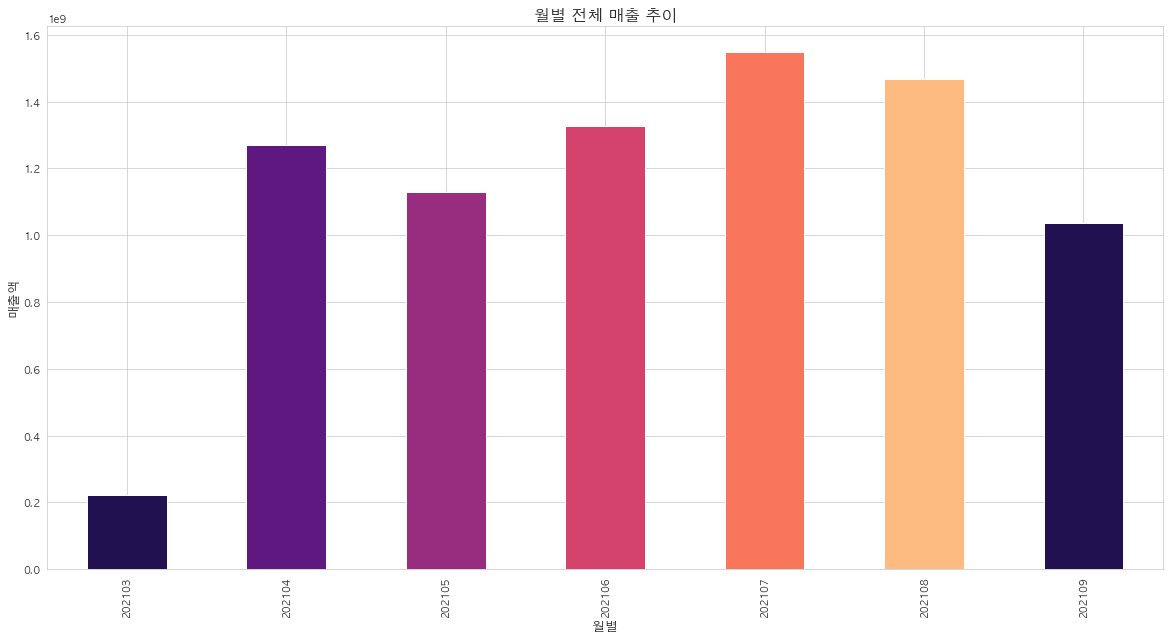

In [12]:
# 월별 매출 추이

rev_by_month = data1.set_index('completed_at').groupby(extract_month).sum()['transaction_amount']
plot_bar(rev_by_month, '월별 전체 매출 추이', '월별', '매출액')

#### 월별 B2C / B2B / B2G 매출비교

In [13]:
# 이후 시각화에 쓰기 위해 월로 변환한 컬럼을 추가한다.

data1['completed_month'] = data1['completed_at'].dt.month
data1['completed_month'] = data1['completed_month'].astype('int32')

# 혹시 'compmleted_month' 생성 후 NaN Row가 1줄 생기면 주석 해제하고 사용
# data1 = data1[pd.notnull(data1['completed_month'])]

In [14]:
# 한개의 플롯에 B2C, B2B, B2G 월별 매출 추이 시각화 위해 
# 'biz_type' 컬럼 생성, 값 할당

data1['biz_type'] = 'b2c'
data1.loc[data1['format'].str.contains('B2G'), 'biz_type'] = 'b2g'
data1.loc[data1['format'].str.contains('B2B'), 'biz_type'] = 'b2b'

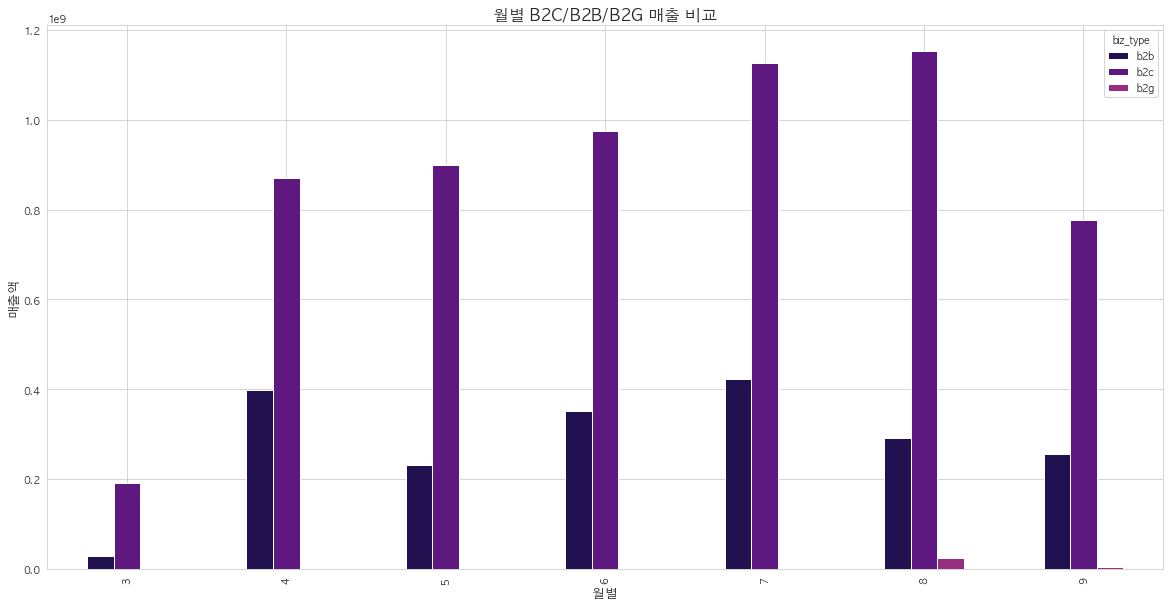

In [15]:
# 피봇 테이블 생성 후 바-플롯
biz_type_pivot = data1.pivot_table(index=['biz_type'], columns='completed_month', values='transaction_amount', aggfunc='sum', sort=True)

plot_bar(biz_type_pivot.T, '월별 B2C/B2B/B2G 매출 비교', '월별', '매출액')

> B2C 매출은 4월 - 8월까지 완만한 상승세로 나타남
>> 9월은 25일 이후 데이터가 누락된 수치

> B2B 매출은 4월과 7월이 높고 기복이 있음
>> 월에 따라 기복이 있는 이유를 파악할 필요 있음
> B2G 매출은 미미한 편이며, 8월에 집중됨

#### 월별 B2C 매출

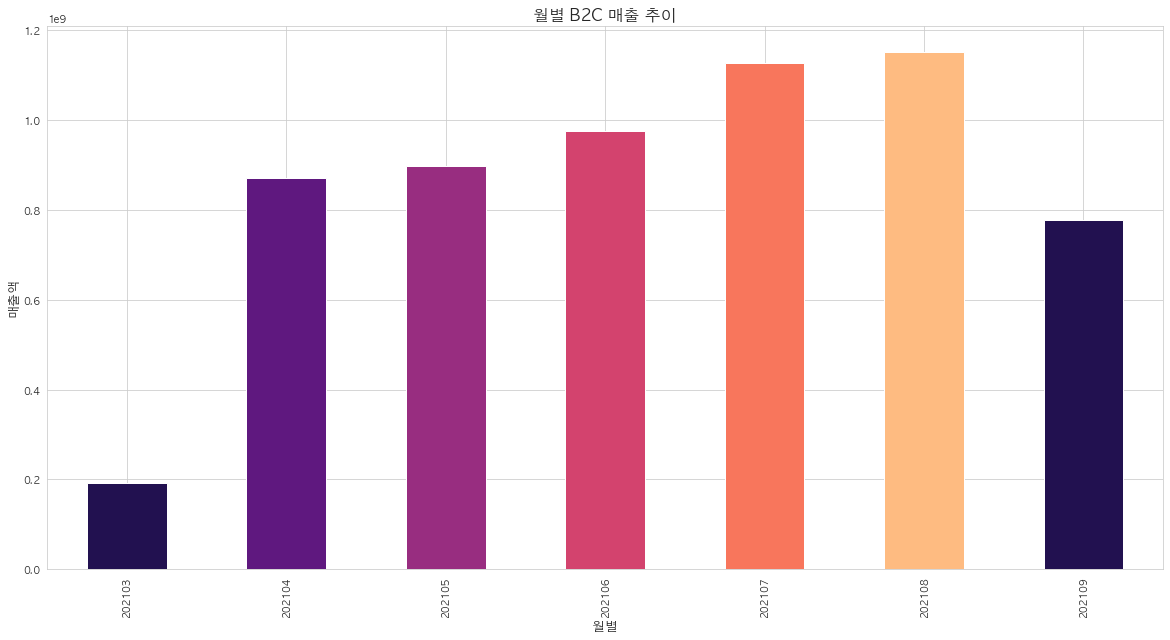

In [16]:
# B2C 거래만 추출

data1_b2c = data1[(~data1.course_title.str.contains('\(B2')) & (~data1['format'].str.contains('B2'))]
data1_b2c['format'].unique()

# B2C 월별 매출 추이

b2c_rev_by_month = data1_b2c.set_index('completed_at').groupby(extract_month).sum()['transaction_amount']
plot_bar(b2c_rev_by_month, '월별 B2C 매출 추이', '월별', '매출액')

> B2C 매출은 매월 증가세, 9월 매출도 8월과 유사 또는 높을 것으로 예상됨

#### 월별 B2B 매출

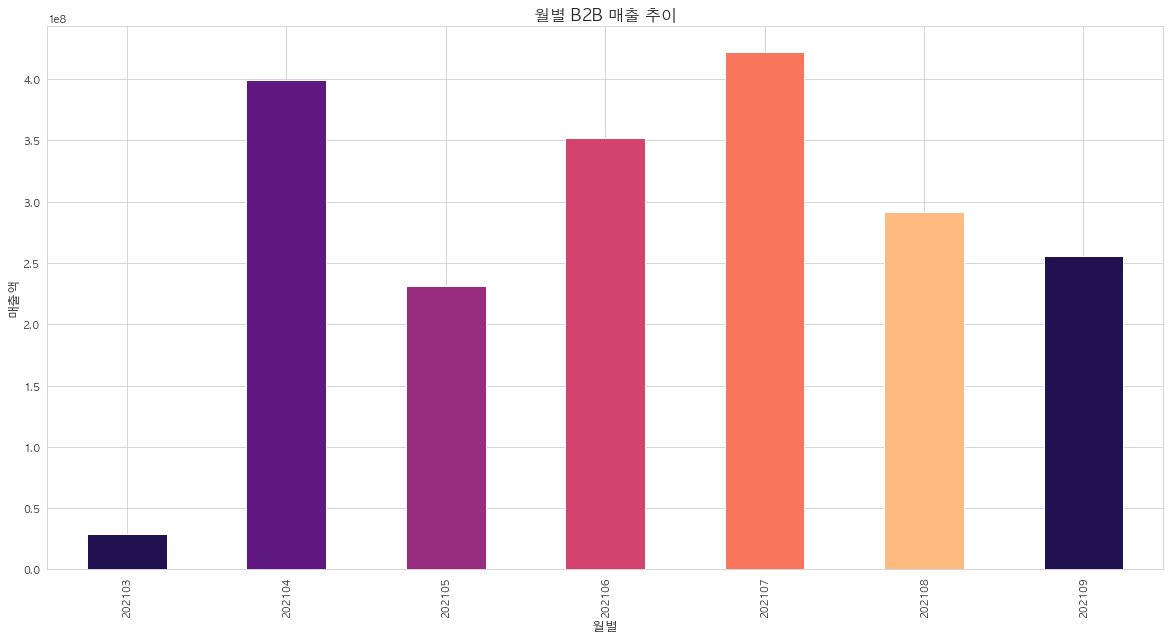

In [17]:
# B2B 거래만 추출

data1_b2b = data1[(data1.course_title.str.contains('\(B2')) & (data1['format'].str.contains('B2B'))]
data1_b2b['format'].unique()

# B2B 월별 매출 추이

b2b_rev_by_month = data1_b2b.set_index('completed_at').groupby(extract_month).sum()['transaction_amount']
plot_bar(b2b_rev_by_month, '월별 B2B 매출 추이', '월별', '매출액')

#### 월별 B2G 매출

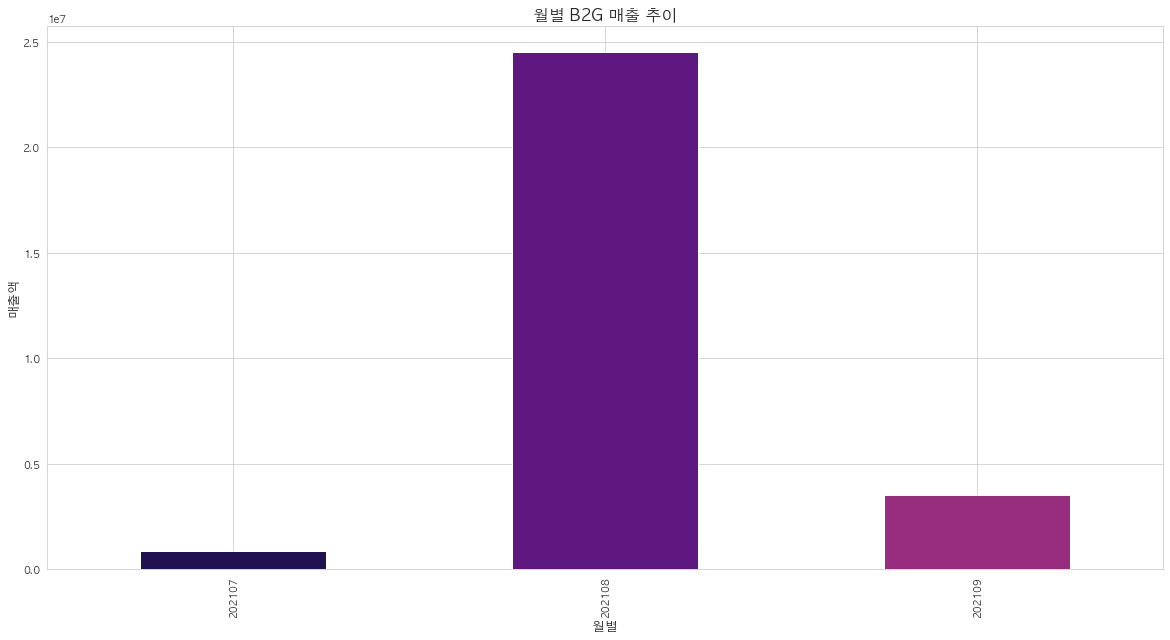

In [18]:
# B2G 거래만 추출

data1_b2g = data1[(data1.course_title.str.contains('\(B2')) & (data1['format'].str.contains('B2G'))]
data1_b2g['format'].unique()

# B2G 월별 매출 추이

b2g_rev_by_month = data1_b2g.set_index('completed_at').groupby(extract_month).sum()['transaction_amount']
plot_bar(b2g_rev_by_month, '월별 B2G 매출 추이', '월별', '매출액')

> B2G 매출이 특정 월에 집중되는 것은 비즈니스 모델의 특성 때문일 것으로 추정
>> 정부 결제 시점이 특정되었을 수 있음

### B2C 매출 분석
#### 일별 B2C 매출 추이

completed_at
2021-08-31    171545683
2021-06-30    142965734
2021-07-31    108108500
2021-05-31     94903589
2021-08-16     92448300
2021-04-30     86059840
2021-03-31     85210797
2021-07-25     83001200
2021-07-30     69931500
2021-06-29     66512755
Name: transaction_amount, dtype: int64

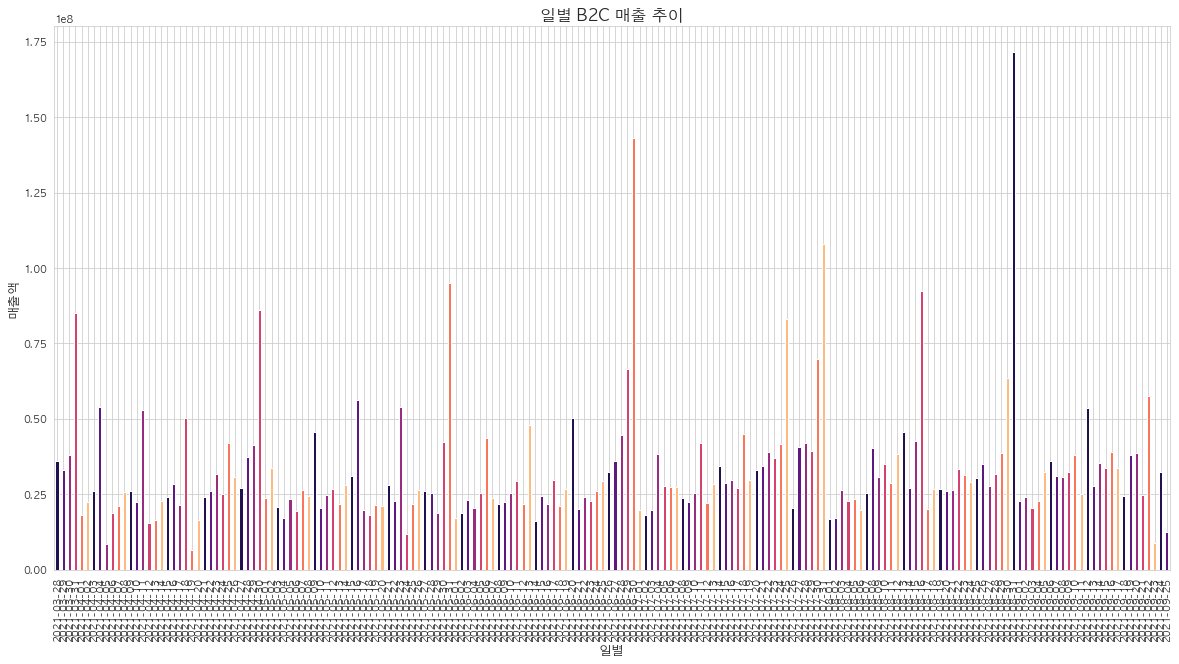

In [19]:
# B2C 매출 추이(일별)

b2c_rev_by_daily = data1_b2c.set_index('completed_at').groupby(lambda date: date.strftime('%Y-%m-%d')).sum()['transaction_amount']
plot_bar(b2c_rev_by_daily, '일별 B2C 매출 추이', '일별', '매출액')

b2c_rev_by_daily.sort_values(ascending=False)[:10]

> 매월 말일 매출이 극단적으로 높게 나타나는 패턴을 보임
>> 이는 고객의 구매행동 특성이거나, 말일에 마케팅 프로모션을 집중시켰기 때문일 것으로 추정

> 7/26, 8/15 매출이 높게 나타난 것이 특이점.
>> 이에 대한 원인을 확인해서 마케팅 전략에 참고할 필요 있음

#### B2C format별 Daily 매출 (범례 : format)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<AxesSubplot:xlabel='completed_at'>

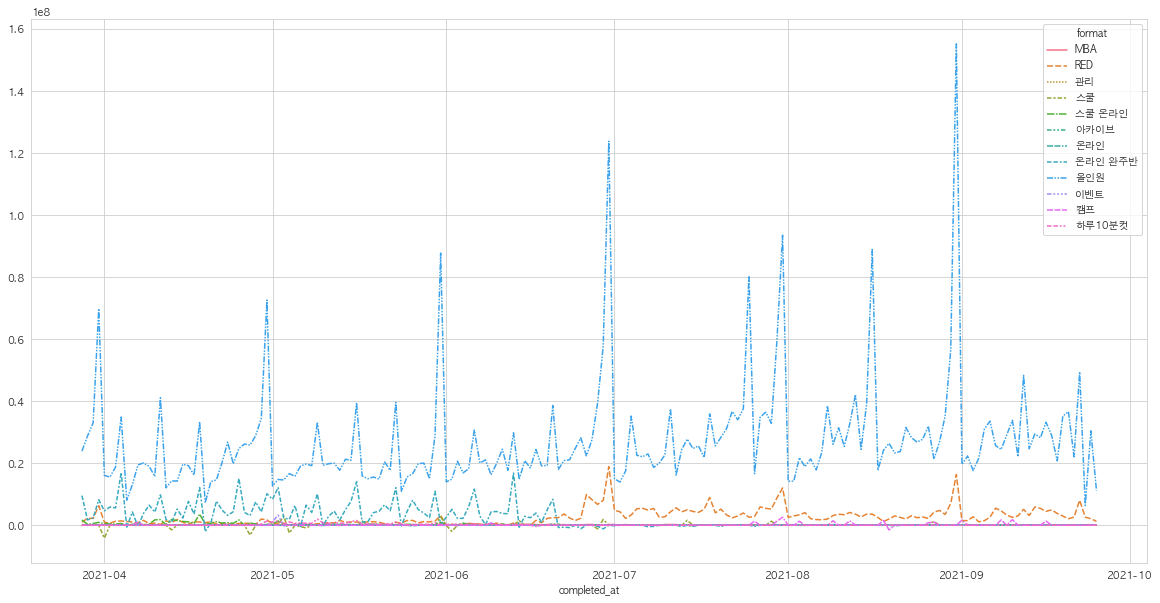

In [20]:
daily_rev_by_format = data1_b2c.pivot_table(values='transaction_amount', index=data1_b2c.format, columns=data1_b2c.completed_at.dt.date
                             , aggfunc='sum', fill_value=0)

plt.figure(figsize = (20, 10))
plt.legend(loc = (1.0, 0))
sns.lineplot(data=daily_rev_by_format.T)

#### 구매가 일어난 올인원 포맷 코스의 종류와 구매빈도의 분포

<AxesSubplot:xlabel='count', ylabel='format'>

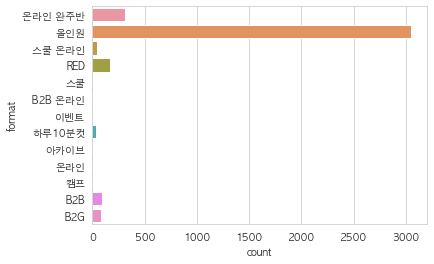

In [21]:
sns.countplot(data=data3,y='format')

#### B2C format별 Monthly 매출 (범례 : format)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<AxesSubplot:xlabel='completed_month'>

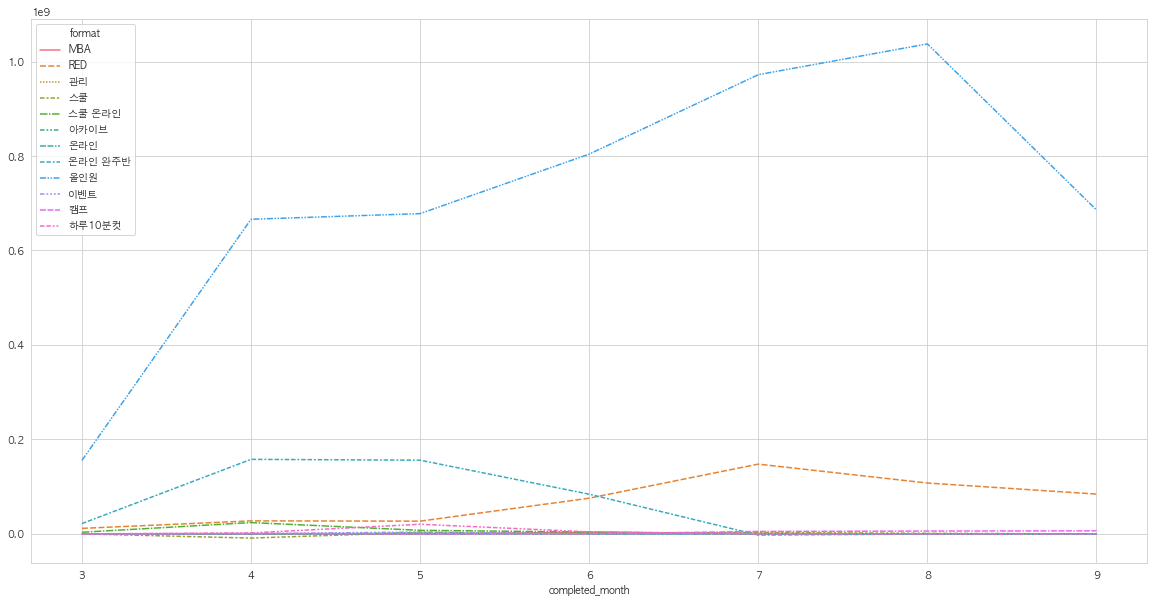

In [22]:
monthly_rev_by_format = data1_b2c.pivot_table(values='transaction_amount', index=data1_b2c.format, columns=data1_b2c.completed_month
                             , aggfunc='sum', fill_value=0)

plt.figure(figsize = (20, 10))
plt.legend(loc = (1.0, 0))
sns.lineplot(data=monthly_rev_by_format.T)

> 올인원 포맷의 일별 매출이 극단적으로 높다.
>> 패스트캠퍼스 상품 포트폴리오의 비중이 특정 포맷에 편중되어 있는 것으로 보임

>> 올인원 포맷은 전체 B2C 매출을 견인하고 있음.

>> 반면, 특정 상품에 의존하는 매출 구조는 장기적으로 리스크로 작용할 수 있음.

>> 새로운 상품군을 발굴해야 한다는 점에서 'RED' 포맷을 유심히 볼 필요가 있음.

#### B2C category_title 별 Daily / Monthly 매출 플롯 (범례 : category_title)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<AxesSubplot:xlabel='completed_at'>

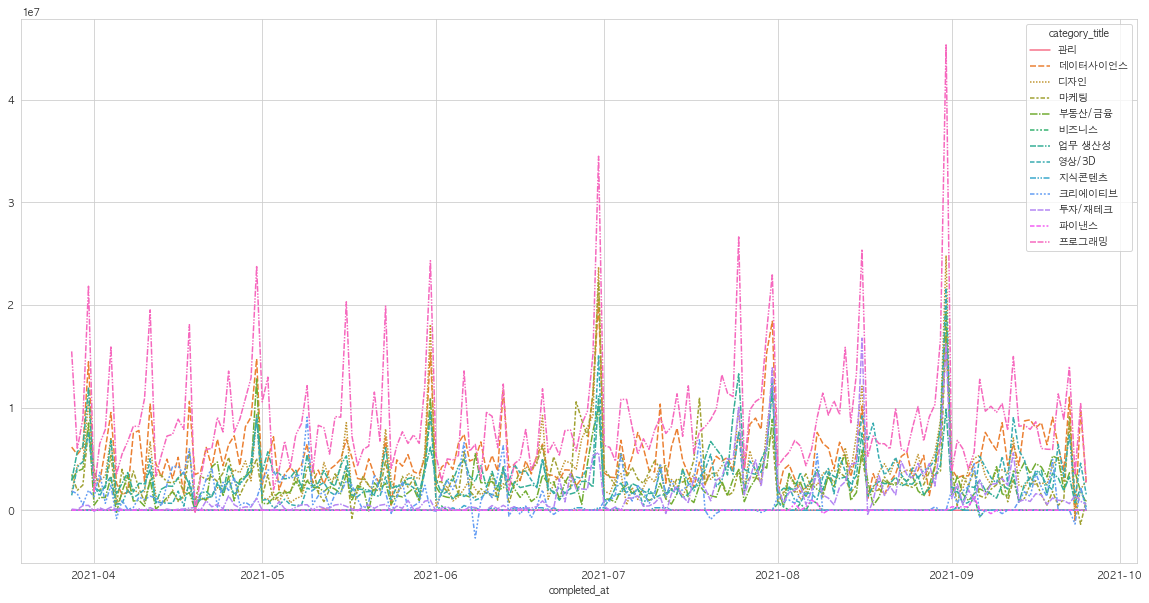

In [23]:
# 카테고리 타이틀별 데일리 매출 

daily_rev_by_cat = data1_b2c.pivot_table(values='transaction_amount', index=data1_b2c.category_title, columns=data1_b2c.completed_at.dt.date
                             , aggfunc='sum', fill_value=0)

plt.figure(figsize = (20, 10))
plt.legend(loc = (1.0, 0))
sns.lineplot(data=daily_rev_by_cat.T)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<AxesSubplot:xlabel='completed_month'>

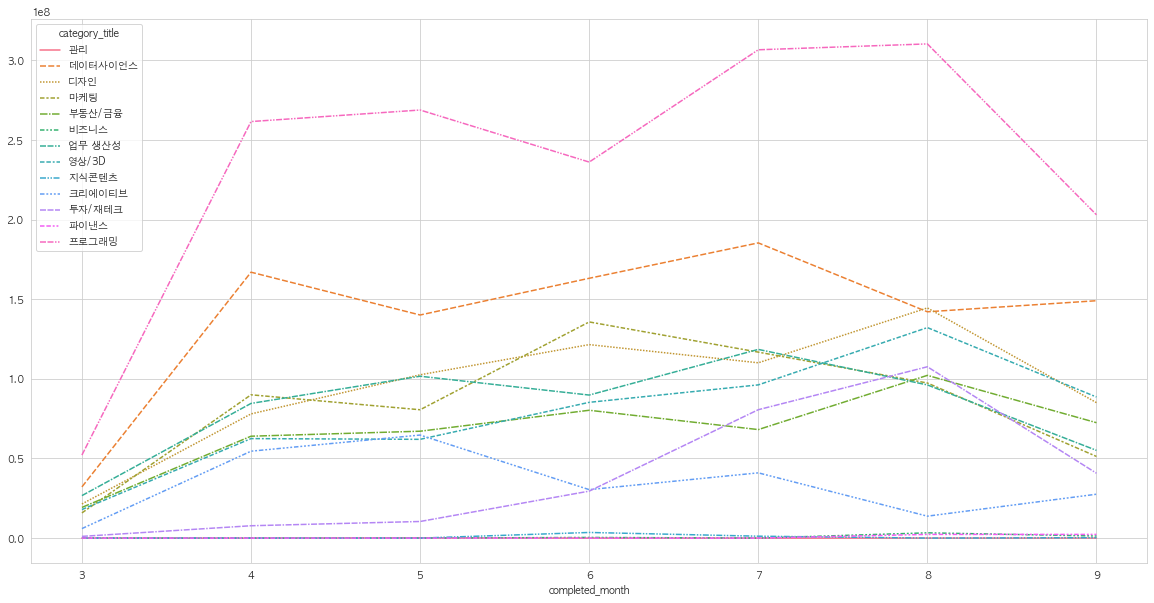

In [24]:
monthly_rev_by_cat = data1_b2c.pivot_table(values='transaction_amount', index=data1_b2c.category_title
                                           , columns=data1_b2c.completed_month, aggfunc='sum', fill_value=0)

plt.figure(figsize = (20, 10))
plt.legend(loc = (1.0, 0))
sns.lineplot(data=monthly_rev_by_cat.T)

> 포맷별 비교에 비해 카테고리별 매출은 상위 5 ~ 6개에 분산되어 있음
>> 반면에 지속적으로 매출이 부진한 하위 카테고리는 패슽트캠퍼스 고객층과 맞지 않는 것인지 파악해 볼 필요 있음
>>> 만약 고객군이 불일치하는 카테고리 라면 새로운 코스를 제작하는 것은 지양할 것을 권고

####  B2C 각 카테고리의 Monthly 주문완료율, 구매전환율, 환불율

### 구매빈도 등 행동패턴 분석
- 구매단계별 소비자 행동 해석  : 결제 완료된 건에 대하여
- [ ] 고객별 구매빈도에 따른 우수고객 발굴
- [ ] Pending율을 통한 매출에 미치는 영향
- [ ] B2C 전체 기간동안 시간대별 결제완료 갯수 (Payment Completed)
- [ ] B2C 전체 기간동안 요일별 결제완료 갯수 (Payment Completed)
- [ ] B2C 1인당 평균구매금액 Daily / Monthly 플롯
- [ ] B2C 구매자별 총구매금액 (Customer_id, transaction_amount)
- [ ] B2C 구매자별 총결제갯수 (Customer_id, Payment Completed)
- [ ] B2C 구매자별 환불갯수 (Customer_id, Refund Completed)
- [ ] B2C 구매갯수 상위 20%의 수강ID별 Monthly 결제갯수 라인 플롯 (Payment Completed)

#### 고객별 구매빈도에 따른 우수고객 발굴

In [58]:
data1_b2c['customer_id'].sort_values()

24979         46
21723         47
67357         47
99308         96
92476        153
           ...  
100425    670748
100441    670787
100439    670817
100447    670833
100457    670891
Name: customer_id, Length: 50129, dtype: int64

In [65]:
data1

id  customer_id  course_id     type      state  \
2        970657        72297   204246.0  PAYMENT  COMPLETED   
4        970658       478028   201797.0  PAYMENT  COMPLETED   
8        970669       478033   203178.0  PAYMENT  COMPLETED   
10       970671       469860   203644.0  PAYMENT  COMPLETED   
14       970676       478035   203720.0  PAYMENT  COMPLETED   
...         ...          ...        ...      ...        ...   
100455  1364969       669238   204286.0  PAYMENT  COMPLETED   
100456  1364976       384003   203178.0  PAYMENT  COMPLETED   
100457  1364991       670891   203935.0  PAYMENT  COMPLETED   
100460  1364996       640697   205365.0  PAYMENT  COMPLETED   
100462  1365007       610626   206720.0  PAYMENT  COMPLETED   

                                          course_title category_title  format  \
2                                 시크릿코드 : 프론트엔드 실무 완성편          프로그래밍  스쿨 온라인   
4                        올인원 패키지 : 직장인 필수 스킬 3종 세트 MAX         업무 생산성     올인원   
8                          초격차 패키지 : 한번에 끝내는 영상 촬영과 편집          영상/3D     올인원   
10      올인원 패키지 : 권오상의 금융 아카데미 - 권오상의 재무제표 분석 기초(평생소장)         부동산/금융     올인원   
14                         초격차 패키지 : 한 번에 끝내는 프론트엔드 개발          프로그래밍     올인원   
...                                                ...            ...     ...   
100455                      초격차 패키지 : 한번에 끝내는 3D 디자인 툴            디자인     올인원   
100456                     초격차 패키지 : 한번에 끝내는 영상 촬영과 편집          영상/3D     올인원   
100457                     초격차 패키지 : 한 번에 끝내는 파이썬 웹 개발          프로그래밍     올인원   
100460                 초격차 패키지 : 한 번에 끝내는 유튜브 크리에이터 되기          영상/3D     올인원   
100462                              용호수의 돈 버는 실전 영상 제작          영상/3D     올인원   

              completed_at  transaction_amount               coupon_title  \
2      2021-03-28 15:21:43              171810      [10% 할인] 시크릿코드 실무 완성편   
4      2021-03-28 15:21:54               97500   [웰컴쿠폰] 올인원 패키지 2만원 할인 쿠폰   
8      2021-03-28 15:26:47               96000   [웰컴쿠폰] 올인원 패키지 2만원 할인 쿠폰   
10     2021-03-28 15:27:17              263000                        NaN   
14     2021-03-28 15:31:01               91000   [웰컴쿠폰] 올인원 패키지 2만원 할인 쿠폰   
...                    ...                 ...                        ...   
100455 2021-09-25 13:39:26              212000    [미래투자금] 온라인 강의 2만원 할인쿠폰   
100456 2021-09-25 13:46:29              149000                        NaN   
100457 2021-09-25 14:01:26              159000    [미래투자금] 온라인 강의 2만원 할인쿠폰   
100460 2021-09-25 14:17:41               96000  [WELCOME] 온라인 강의 2만원 할인쿠폰   
100462 2021-09-25 14:25:47              139000  [WELCOME] 온라인 강의 3만원 할인쿠폰   

        coupon_discount_amount  sale_price  tax_free_amount          pg  \
2                      19090.0      190900           190900  fastcampus   
4                      20000.0      117500           117500  fastcampus   
8                      20000.0      116000           116000  fastcampus   
10                         0.0      263000           263000  fastcampus   
14                     20000.0      111000           111000  fastcampus   
...                        ...         ...              ...         ...   
100455                 20000.0      232000           232000      INICIS   
100456                     0.0      149000           149000       KAKAO   
100457                 20000.0      179000           179000      INICIS   
100460                 20000.0      116000           116000      INICIS   
100462                 30000.0      169000           169000       NAVER   

       method subcategory_title marketing_start_at  completed_month biz_type  
2        CARD               NaN         2021-03-04                3      b2c  
4        CARD           PPT/보고서         2019-11-14                3      b2c  
8        CARD             영상 편집         2020-12-02                3      b2c  
10       CARD               NaN         2020-11-27                3      b2c  
14       CARD          프론트엔드 개발         2021-02-02            

In [60]:
# type('customer_id')
data1['customer_id'].value_counts().iplot(kind= 'bar',theme='ggplot')#, xTitle ='고객 ID', yTitle = '상품 구매 개수', title = '고객별 구매빈도' )

/Users/di-n/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



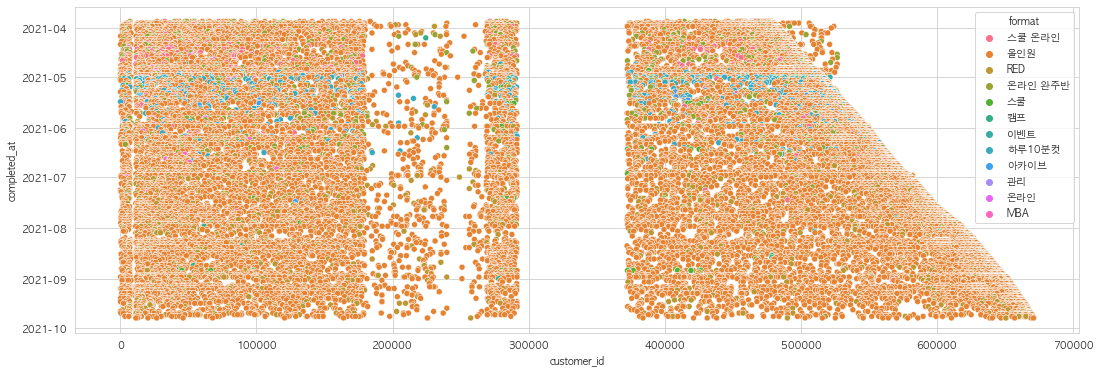

In [71]:
plt.figure(figsize=(18, 6))
sns.scatterplot(data1_b2c['customer_id'] ,data1_b2c['completed_at'].dt.date , data1_b2c['format'])
plt.show()

In [27]:
# 실행 타임 엄청 오래 걸림... ㅠㅠ 왜죠??? 슬라이싱도 안됨. 왜죠???

data1_pay_completed = data1_b2c[(data1_b2c['type'] == 'PAYMENT') & (data1_b2c['state'] == 'COMPLETED')]
vip_by_count = data1_pay_completd.set_index('customer_id').groupby('customer_id').count()['course_id']
# plot_bar(vip_by_count, '고객별 구매빈도 분석', '고객', '구매횟수')

NameError: name 'data1_pay_completd' is not defined

In [ ]:
# plt.bar(x=vip_by_count.index, height=vip_by_count.values, data=vip_by_count)

In [ ]:
# vip_by_count.sort_values(ascending=False)
# sns.set_style('whitegrid')
# plt.rcParams['font.family'] = 'Malgun Gothic'
# vip_by_count[:100].plot(kind='bar', color=COLORS, figsize=(20, 10))

# sns.set_style('whitegrid')
# plt.rcParams['font.family'] = 'Malgun Gothic' # 한글폰트 : 나눔고딕 설정
# plot = df.plot(kind='bar', color=COLORS, figsize=(20, 10))
# plot.set_title(title, fontsize=16)
# plot.set_xlabel(xlabel, fontsize=13)
# plot.set_ylabel(ylabel, fontsize=13)
# plot.set_xticklabels(labels=df.index, rotation=90)

#### Pending율을 통한 매출에 미치는 영향

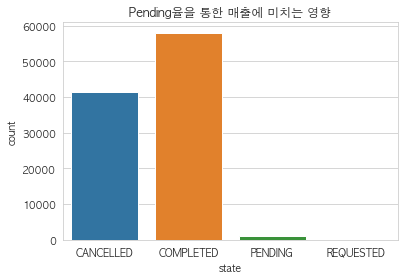

In [30]:
sns.countplot(x="state", data=df)
plt.title("Pending율을 통한 매출에 미치는 영향")
plt.show()

#### 시간대별 B2C 결제완료 갯수 (Payment Completed)

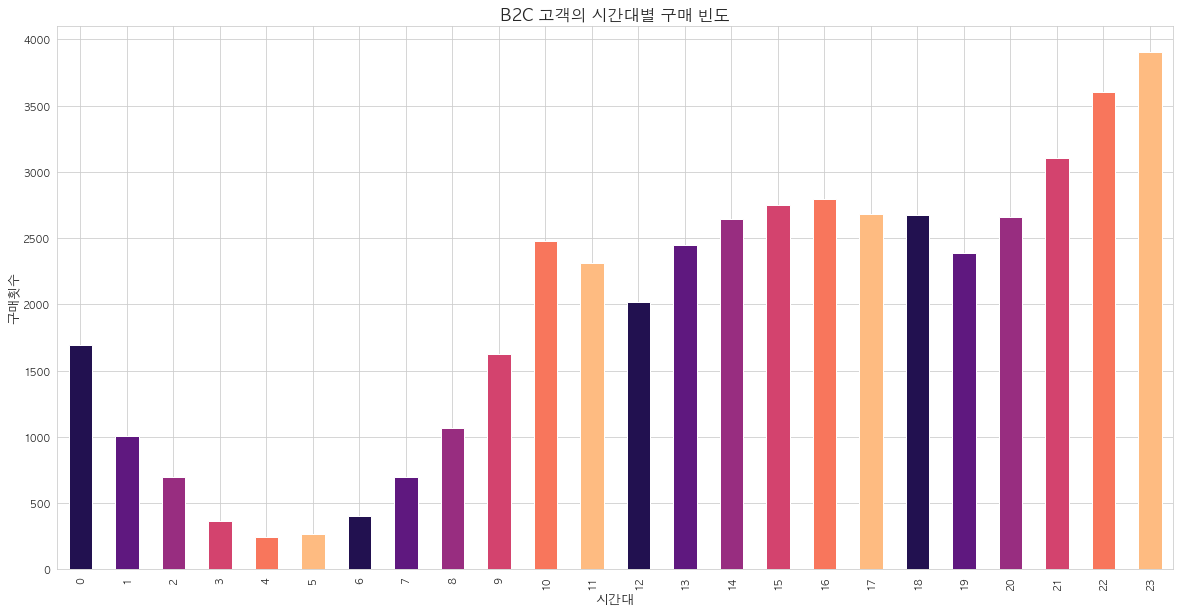

In [29]:
rev_by_hour = data1_pay_completed.set_index('completed_at').groupby(lambda date: date.hour).count()['state']
plot_bar(rev_by_hour, 'B2C 고객의 시간대별 구매 빈도', '시간대', '구매횟수')

> 6시 부터 결제가 증가했다가 낮 12시에 잠시 감소하고 이후 다시 증가세

> 특히 21시 ~ 자정까지 시간데에 결제가 많이 일어나고 있음
>> 할인쿠폰, 이벤트 등 알림을 한다면 낮 12시대, 밤 20시대에 보내서 결제를 유도할 것을 권고

>> 결제가 많이 일어나는 시간에 접속하는 수강생에게 로그인 후 특별혜택을 제공하는 업셀링 마케팅을 시도해서 추가 구매를 유도하는 액션을 검토해 볼 것을 권고

#### 요일별 결제완료 갯수 (Payment Completed)

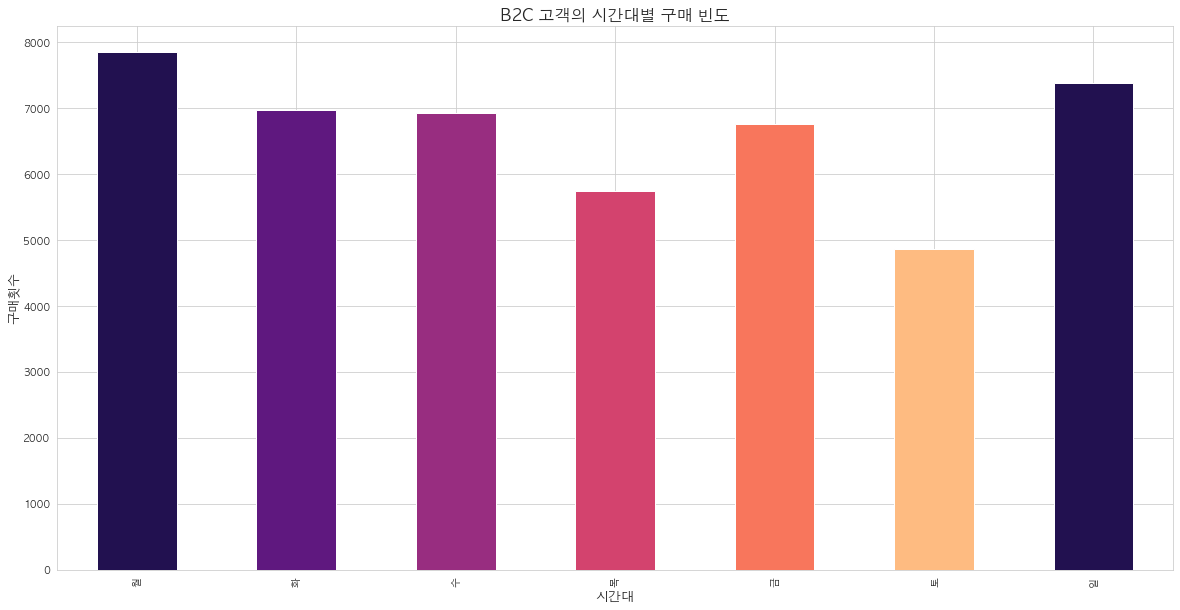

In [28]:
rev_by_dow = data1_pay_completed.set_index('completed_at').groupby(lambda date: date.dayofweek).count()['state']
week = np.array(['월', '화', '수', '목', '금', '토', '일'])
rev_by_dow.index = week[rev_by_dow.index]
plot_bar(rev_by_dow, 'B2C 고객의 시간대별 구매 빈도', '시간대', '구매횟수')

> 목요일과 토요일에 구매가 낮게 나타남
> 일요일과 월요일 구매가 가장 높게 나타남
>> 일요일에 잠재고객군을 대상으로 모바일 프로모션을 검토해 볼 것을 권고

#### 1인당 평균구매금액 Daily / Monthly

In [ ]:

rev_by_customer = data1_pay_completed.pivot_table(index='customer_id', columns=data1_pay_completed.completed_at.dt.date
                                                  , values='transaction_amount', aggfunc='mean').sort_values(by='customer_id', ascending=False)

# 실행 타임 엄청 오래 걸림... ㅠㅠ 왜죠??? 슬라이싱도 안됨, 왜죠???

# plot_bar(rev_by_customer, '1인당 평균구매금액', '고객', '평균구매금액')

# rev_by_customer.sort_values(by='transaction_amount', ascending=False)

In [ ]:
# vip_by_count_copy.sort_values(ascending=False)

#### 맥북 패스 프로모션에 대한 고객 반응 분석
> [MacBook PASS] 1차: 9/20(월) - 9/22(수) 23:59, 2차(앵콜): 9/23(목) - 9/26(일) 23:59, Pro패스 / Air패스

> 총 39개 판매, 프로모션 매출 : 65,000,000원 (코스 매출 10,946,000원)

In [31]:
# 맥북 패스 프로모션 판매 갯수
data1_pay_completed[data1_pay_completed['course_title'].str.contains('맥북')]['completed_at'].value_counts().sum() 

39

In [32]:
# 맥북 패스 프로모션 매출
data1_pay_completed[data1_pay_completed['course_title'].str.contains('맥북')]['transaction_amount'].sum() 

65000000

In [33]:
# 맥북 패스 프로모션을 통한 코스 매출
data1_pay_completed[data1_pay_completed['course_title'].str.contains('맥북')]['tax_free_amount'].sum() # 10,946,000원

10946000

In [34]:
# macbookpro_event_buytime = data1_pay_completed[data1_pay_completed['course_title'].str.contains('맥북')].set_index('completed_at').groupby(lambda date: date.hour).count()['customer_id']
macbookpro_event_buyday = data1_pay_completed[data1_pay_completed['course_title'].str.contains('맥북')].set_index('completed_at').groupby(lambda date: date.day).count()['customer_id']
macbookpro_event_buydow = data1_pay_completed[data1_pay_completed['course_title'].str.contains('맥북')].set_index('completed_at').groupby(lambda date: date.dayofweek).count()['customer_id']
macbookpro_event_buycourse = data1_pay_completed[data1_pay_completed['course_title'].str.contains('맥북')].groupby('course_title').count()['customer_id']

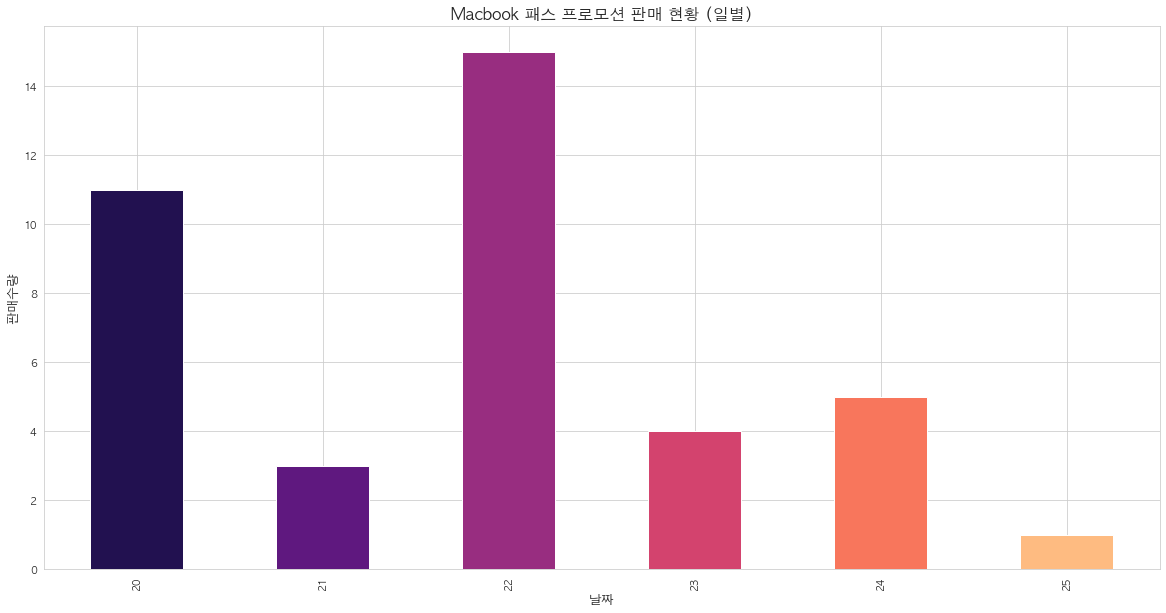

In [35]:
plot_bar(macbookpro_event_buyday, 'Macbook 패스 프로모션 판매 현황 (일별)', '날짜', '판매수량')

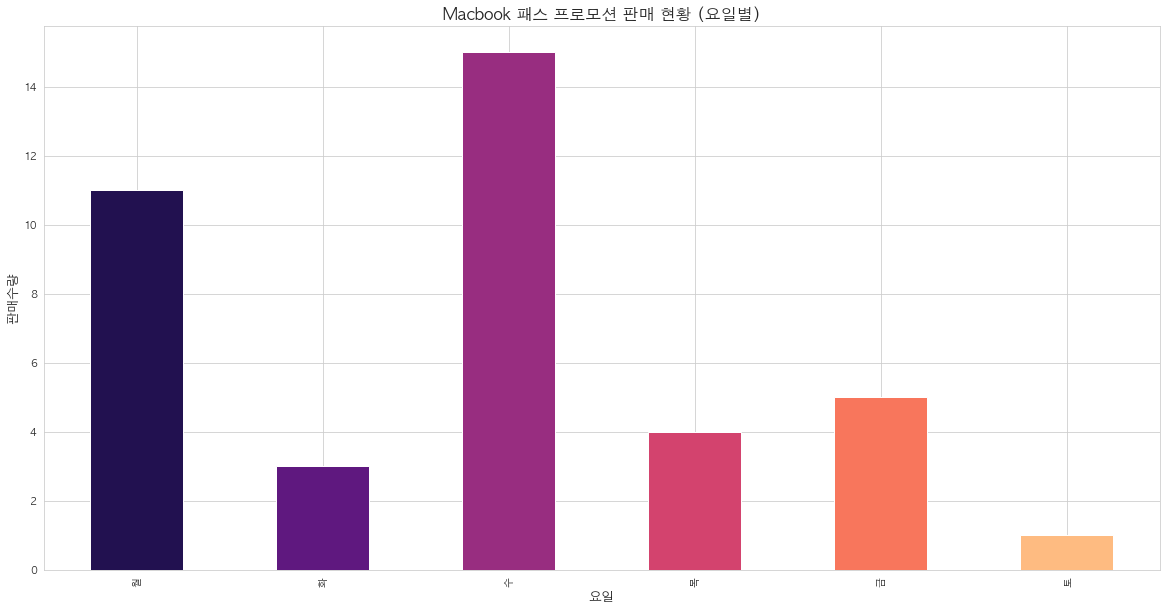

In [36]:
macbookpro_event_buydow.index = week[macbookpro_event_buydow.index]
plot_bar(macbookpro_event_buydow, 'Macbook 패스 프로모션 판매 현황 (요일별)', '요일', '판매수량')

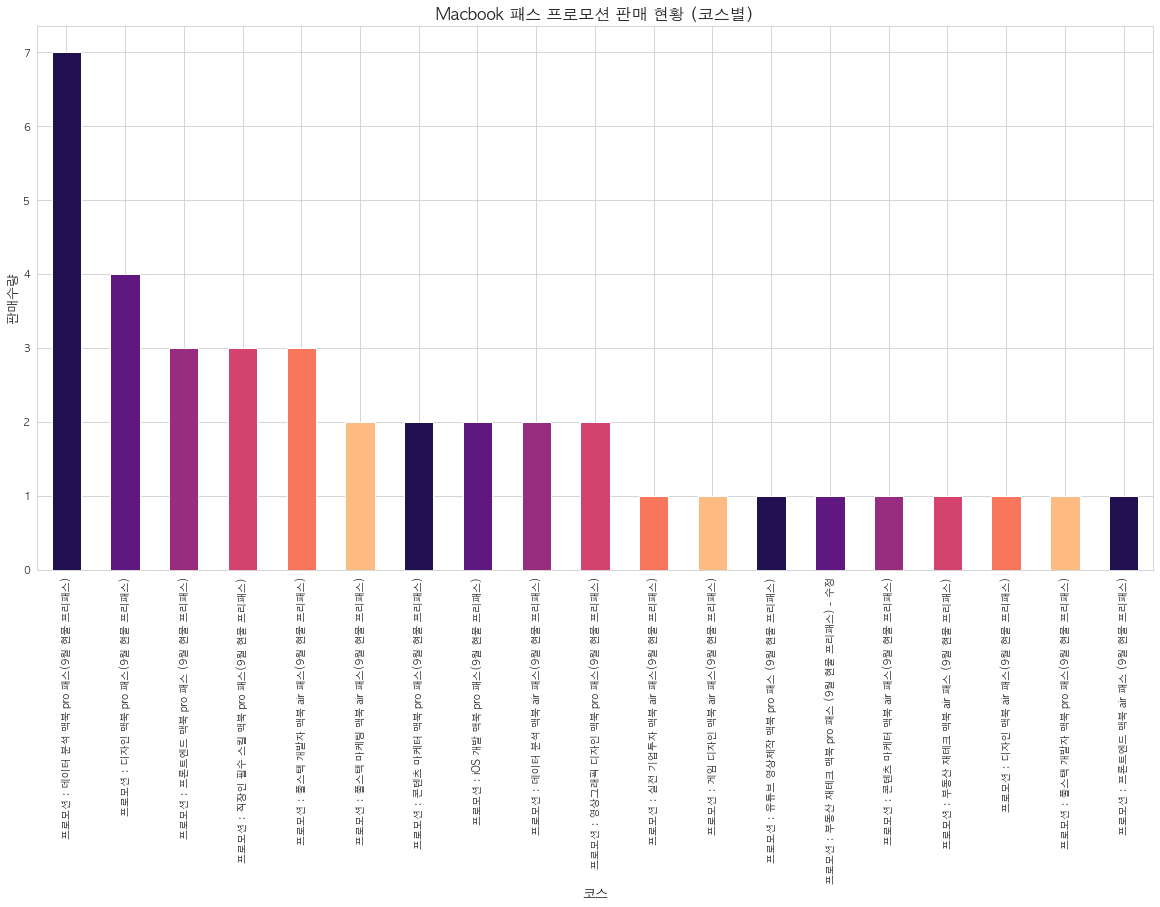

In [37]:
plot_bar(macbookpro_event_buycourse.sort_values(ascending=False), 'Macbook 패스 프로모션 판매 현황 (코스별)', '코스', '판매수량')

In [38]:
kyh_count_by_date = data1_pay_completed[data1_pay_completed['course_title'].str.contains('김영하')].set_index('completed_at').groupby(lambda date: date.strftime('%Y-%m-%d')).count()['customer_id']
kyh_rev_by_date = data1_pay_completed[data1_pay_completed['course_title'].str.contains('김영하')].set_index('completed_at').groupby(lambda date: date.strftime('%Y-%m-%d')).sum()['transaction_amount']

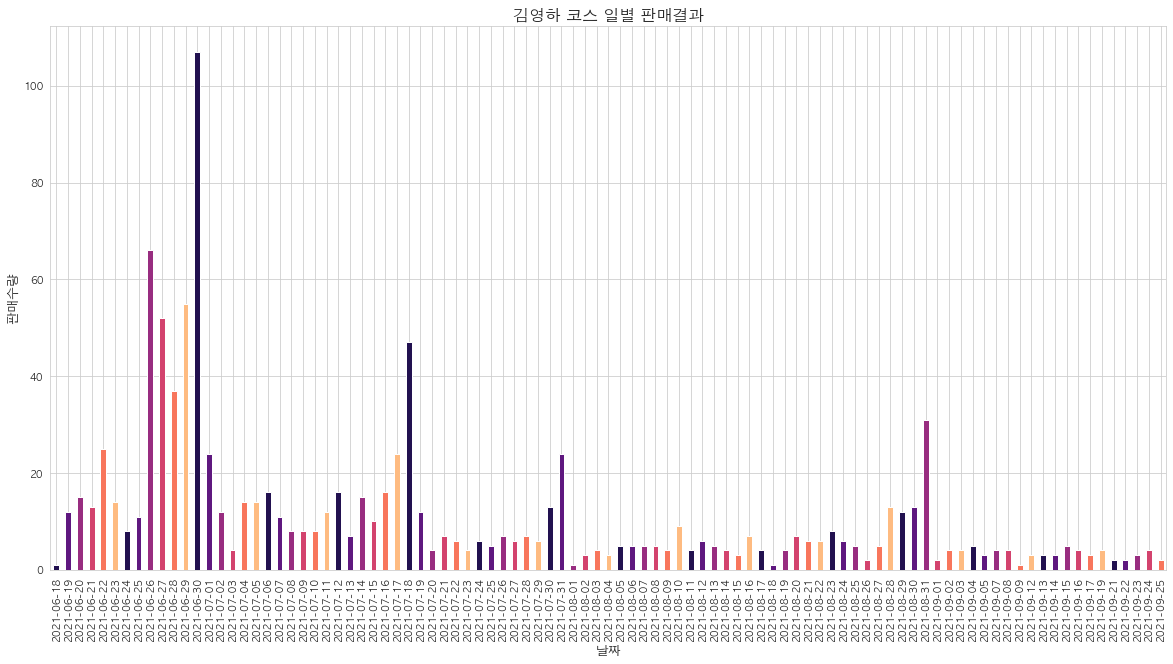

In [39]:
plot_bar(kyh_count_by_date, '김영하 코스 일별 판매결과', '날짜', '판매수량')

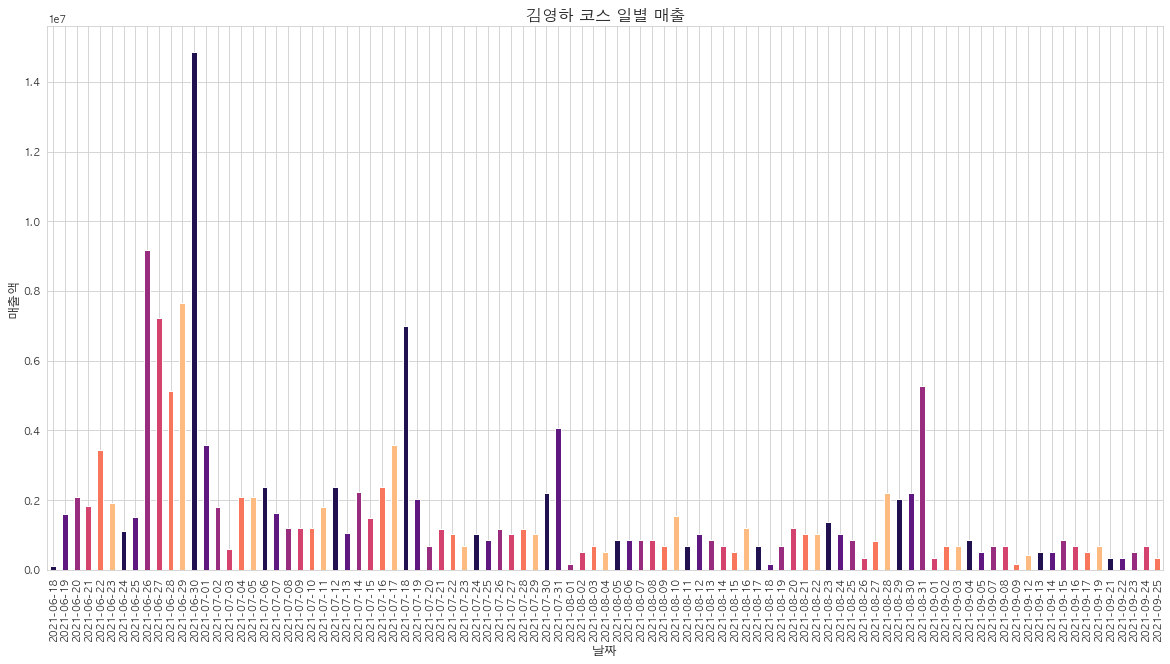

In [40]:
plot_bar(kyh_rev_by_date, '김영하 코스 일별 매출', '날짜', '매출액')

In [41]:
# kyh_b2b_rev_by_date = data1_b2b[data1_b2b['course_title'].str.contains('김영하')].set_index('completed_at').groupby(lambda date: date.strftime('%Y-%m-%d')).sum()['transaction_amount']
# plot_bar(kyh_b2b_rev_by_date, 'B2B 김영하 코스 매출 분석', '날짜', '매출')

In [42]:
pd.to_datetime('2021-09-26') - data1['marketing_start_at'].min()

Timedelta('1024 days 00:00:00')

#### 구매자별 총구매금액 (Customer_id, transaction_amount)

<AxesSubplot:xlabel='customer_id'>

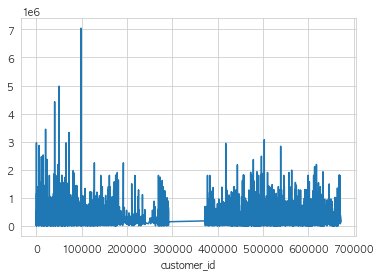

In [73]:
date_quantity_series = data1_pay_completed.groupby('customer_id')['transaction_amount'].sum()
date_quantity_series.plot()

#### 구매자별 총결제갯수 (Customer_id, Payment Completed)

#### 구매자별 환불갯수 (Customer_id, Refund Completed)

In [91]:
def rates(x,y):
    z = (y/x) * 100
    return z

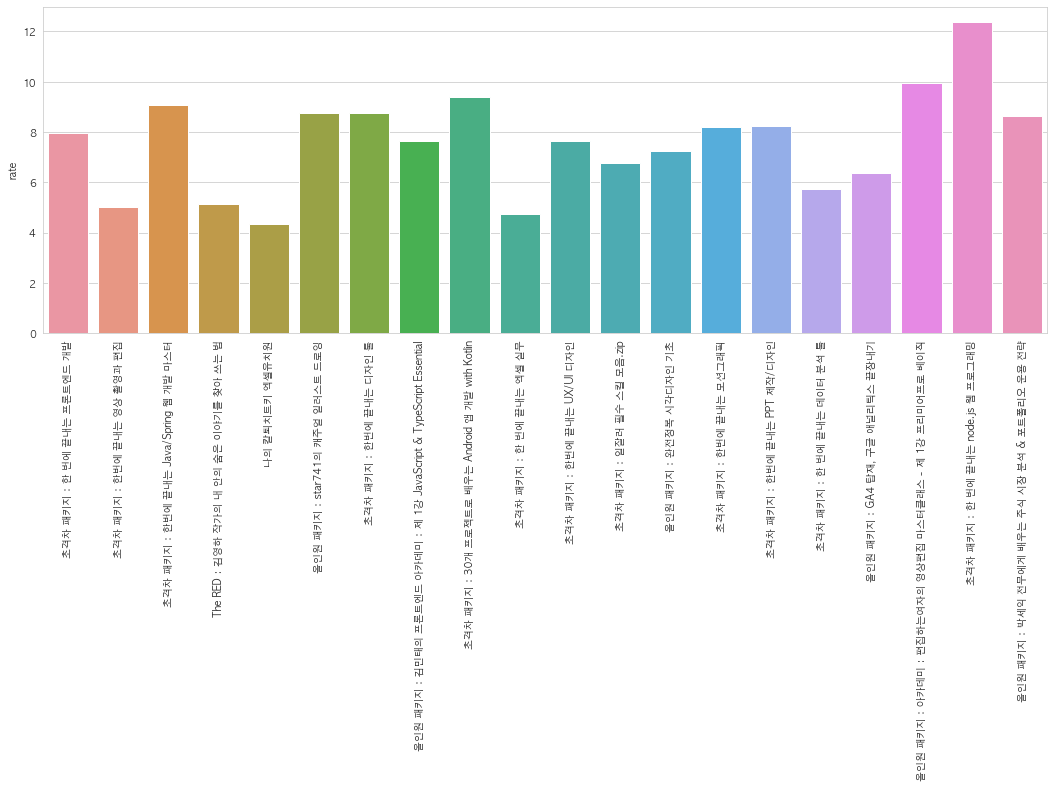

In [151]:
plt.figure(figsize=(18, 6))
plt.xticks(rotation=90)
sns.barplot(x=df_refund_rate.index, y=df_refund_rate['rate'])
plt.show()



In [155]:
df_ab = pd.concat([df_a , df_b], axis = 1)
df_ab['rate'] = round(df_ab['REFUND'] / df_ab['COMPLETED' ] * 100 , 2)
df_refund_rate = df_ab.sort_values(by = 'COMPLETED', ascending=False)[:20]
df_refund_rate


COMPLETED  REFUND   rate
초격차 패키지 : 한 번에 끝내는 프론트엔드 개발                            1520.0   121.0   7.96
초격차 패키지 : 한번에 끝내는 영상 촬영과 편집                            1200.0    60.0   5.00
초격차 패키지 : 한번에 끝내는 Java/Spring 웹 개발 마스터                 1157.0   105.0   9.08
The RED : 김영하 작가의 내 안의 숨은 이야기를 찾아 쓰는 법                 1107.0    57.0   5.15
나의 칼퇴치트키 엑셀유치원                                          785.0    34.0   4.33
올인원 패키지 : star741의 캐주얼 일러스트 드로잉                         743.0    65.0   8.75
초격차 패키지 : 한번에 끝내는 디자인 툴                                 718.0    63.0   8.77
올인원 패키지 : 김민태의 프론트엔드 아카데미 : 제 1강 JavaScript & T...      692.0    53.0   7.66
초격차 패키지 : 30개 프로젝트로 배우는 Android 앱 개발 with Kotlin        672.0    63.0   9.38
초격차 패키지 : 한 번에 끝내는 엑셀 실무                                654.0    31.0   4.74
초격차 패키지 : 한번에 끝내는 UX/UI 디자인                             654.0    50.0   7.65
초격차 패키지 : 일잘러 필수 스킬 모음.zip                              637.0    43.0   6.75
올인원 패키지 : 완전정복 시각디자인 기초                                 636.0    46.0   7.23
초격차 패키지 : 한번에 끝내는 모션그래픽                                 611.0    50.0   8.18
초격차 패키지 : 한번에 끝내는 PPT 제작/디자인                            606.0    50.0   8.25
초격차 패키지 : 한 번에 끝내는 데이터 분석 툴                             594.0    34.0   5.72
올인원 패키지 : GA4 탑재, 구글 애널리틱스 끝장내기                         567.0    36.0   6.35
올인원 패키지 : 아카데미 : 편집하는여자의 영상편집 마스터클래스 - 제 1강 프리미...      553.0    55.0   9.95
초격차 패키지 : 한 번에 끝내는 node.js 웹 프로그래밍                      550.0    68.0  12.36
올인원 패키지 : 박세익 전무에게 배우는 주식 시장 분석 & 포트폴리오 운용 전략           544.0    47.0   8.64

In [156]:
df_refund_rate['rate'].mean()

7.594999999999999

In [125]:
df_aa = data1_b2c.rename(columns = {'course_title' : 'COMPLETED'})
df_aa

id  customer_id  course_id     type      state  \
2        970657        72297   204246.0  PAYMENT  COMPLETED   
4        970658       478028   201797.0  PAYMENT  COMPLETED   
8        970669       478033   203178.0  PAYMENT  COMPLETED   
10       970671       469860   203644.0  PAYMENT  COMPLETED   
14       970676       478035   203720.0  PAYMENT  COMPLETED   
...         ...          ...        ...      ...        ...   
100455  1364969       669238   204286.0  PAYMENT  COMPLETED   
100456  1364976       384003   203178.0  PAYMENT  COMPLETED   
100457  1364991       670891   203935.0  PAYMENT  COMPLETED   
100460  1364996       640697   205365.0  PAYMENT  COMPLETED   
100462  1365007       610626   206720.0  PAYMENT  COMPLETED   

                                             COMPLETED category_title  format  \
2                                 시크릿코드 : 프론트엔드 실무 완성편          프로그래밍  스쿨 온라인   
4                        올인원 패키지 : 직장인 필수 스킬 3종 세트 MAX         업무 생산성     올인원   
8                          초격차 패키지 : 한번에 끝내는 영상 촬영과 편집          영상/3D     올인원   
10      올인원 패키지 : 권오상의 금융 아카데미 - 권오상의 재무제표 분석 기초(평생소장)         부동산/금융     올인원   
14                         초격차 패키지 : 한 번에 끝내는 프론트엔드 개발          프로그래밍     올인원   
...                                                ...            ...     ...   
100455                      초격차 패키지 : 한번에 끝내는 3D 디자인 툴            디자인     올인원   
100456                     초격차 패키지 : 한번에 끝내는 영상 촬영과 편집          영상/3D     올인원   
100457                     초격차 패키지 : 한 번에 끝내는 파이썬 웹 개발          프로그래밍     올인원   
100460                 초격차 패키지 : 한 번에 끝내는 유튜브 크리에이터 되기          영상/3D     올인원   
100462                              용호수의 돈 버는 실전 영상 제작          영상/3D     올인원   

              completed_at  transaction_amount               coupon_title  \
2      2021-03-28 15:21:43              171810      [10% 할인] 시크릿코드 실무 완성편   
4      2021-03-28 15:21:54               97500   [웰컴쿠폰] 올인원 패키지 2만원 할인 쿠폰   
8      2021-03-28 15:26:47               96000   [웰컴쿠폰] 올인원 패키지 2만원 할인 쿠폰   
10     2021-03-28 15:27:17              263000                        NaN   
14     2021-03-28 15:31:01               91000   [웰컴쿠폰] 올인원 패키지 2만원 할인 쿠폰   
...                    ...                 ...                        ...   
100455 2021-09-25 13:39:26              212000    [미래투자금] 온라인 강의 2만원 할인쿠폰   
100456 2021-09-25 13:46:29              149000                        NaN   
100457 2021-09-25 14:01:26              159000    [미래투자금] 온라인 강의 2만원 할인쿠폰   
100460 2021-09-25 14:17:41               96000  [WELCOME] 온라인 강의 2만원 할인쿠폰   
100462 2021-09-25 14:25:47              139000  [WELCOME] 온라인 강의 3만원 할인쿠폰   

        coupon_discount_amount  sale_price  tax_free_amount          pg  \
2                      19090.0      190900           190900  fastcampus   
4                      20000.0      117500           117500  fastcampus   
8                      20000.0      116000           116000  fastcampus   
10                         0.0      263000           263000  fastcampus   
14                     20000.0      111000           111000  fastcampus   
...                        ...         ...              ...         ...   
100455                 20000.0      232000           232000      INICIS   
100456                     0.0      149000           149000       KAKAO   
100457                 20000.0      179000           179000      INICIS   
100460                 20000.0      116000           116000      INICIS   
100462                 30000.0      169000           169000       NAVER   

       method subcategory_title marketing_start_at  completed_month biz_type  
2        CARD               NaN         2021-03-04                3      b2c  
4        CARD           PPT/보고서         2019-11-14                3      b2c  
8        CARD             영상 편집         2020-12-02                3      b2c  
10       CARD               NaN         2020-11-27                3      b2c  
14       CARD          프론트엔드 개발         2021-02-02            

In [130]:
df_a = df_aa['COMPLETED'].value_counts()

In [129]:
df_b = df_bb['REFUND'].value_counts()


In [123]:
df_bb = data3.rename(columns = {'course_title' : 'REFUND'})
df_bb

id  customer_id  course_id    type      state  \
631      972377       444760   204122.0  REFUND  COMPLETED   
632      972381       472666   203178.0  REFUND  COMPLETED   
644      972409       447177   203989.0  REFUND  COMPLETED   
650      972422       373915   204264.0  REFUND  COMPLETED   
653      972436       456086        NaN  REFUND  COMPLETED   
...         ...          ...        ...     ...        ...   
100218  1363708       600073   206065.0  REFUND  COMPLETED   
100224  1363721       645911        NaN  REFUND  COMPLETED   
100252  1363934       506356   206720.0  REFUND  COMPLETED   
100292  1364149       604077   205569.0  REFUND  COMPLETED   
100295  1364217       552100   203525.0  REFUND  COMPLETED   

                                                  REFUND category_title  \
631                               퍼포먼스 마케터 되기 온라인 완주반 2기            마케팅   
632                          초격차 패키지 : 한번에 끝내는 영상 촬영과 편집          영상/3D   
644                   올인원 패키지 : 소금툰과 함께 캐릭터 드로잉/굿즈/임티/컷툰            디자인   
650                            데이터분석 프로젝트+자격증 온라인 완주반 3기        데이터사이언스   
653               프로모션 :연봉 앞자리가 바뀌는 프론트엔드 한끝세트 (3월 프리패스)          프로그래밍   
...                                                  ...            ...   
100218  (프로모션 7/16-7/29) 초격차 패키지 : 한 번에 끝내는 Spring 완.전.판          프로그래밍   
100224              프로모션 : 콘텐츠 마케터 맥북 air 패스(9월 현물 프리패스)            마케팅   
100252                                용호수의 돈 버는 실전 영상 제작          영상/3D   
100292                     올인원 패키지 : 공여사와 무작정 풀어보는 엑셀 실무         업무 생산성   
100295            초격차 패키지 : 한번에 끝내는 Java/Spring 웹 개발 마스터          프로그래밍   

         format        completed_at  transaction_amount coupon_title  \
631     온라인 완주반 2021-03-29 09:24:43             -147000          NaN   
632         올인원 2021-03-29 09:26:13              -96000          NaN   
644         올인원 2021-03-29 09:40:54              -79000          NaN   
650     온라인 완주반 2021-03-29 09:44:01             -340000          NaN   
653         올인원 2021-03-29 09:47:17             -299000          NaN   
...         ...                 ...                 ...          ...   
100218      올인원 2021-09-24 14:34:50             -149000          NaN   
100224      올인원 2021-09-24 14:41:35            -1400000          NaN   
100252      올인원 2021-09-24 16:10:55             -259000          NaN   
100292      올인원 2021-09-24 17:09:30             -109000          NaN   
100295      올인원 2021-09-24 17:33:53             -108186          NaN   

        coupon_discount_amount  sale_price  tax_free_amount      pg method  \
631                        0.0      404000           404000     NaN  VBANK   
632                        0.0      116000           116000     NaN   CARD   
644                        0.0       89000            89000     NaN   CARD   
650                        0.0      340000           340000     NaN  VBANK   
653                        0.0      299000           299000     NaN   CARD   
...                        ...         ...              ...     ...    ...   
100218                     0.0      179000           179000   NAVER   CARD   
100224                     0.0     1400000           251600  INICIS   CARD   
100252                     0.0      259000           259000   NAVER   CARD   
100292                     0.0      129000           129000   KAKAO  POINT   
100295                     0.0      114000           114000  INICIS   CARD   

       subcategory_title marketing_start_at  
631                  NaN                NaT  
632                영상 편집         2020-12-02  
644                 일러스트         2021-02-19  
650                  NaN         2021-03-08  
653                  NaN                NaT  
...                  ...                ...  
100218            백엔드 개발         2021-07-15  
100224               NaN                NaT  
100252             영상 편집         2021-08-17  
100292            엑셀/VBA         2021-08-17  
100295            백엔드 개발         2021-02-01  

[3809 rows x

In [ ]:
data1_b2c.set_index('completed_at').groupby(lambda date: date.strftime('%Y-%m-%d')).sum()['transaction_amount']

In [ ]:
data1_b2c.pivot_table(values='transaction_amount', index=data1_b2c.course_title
                                           , columns=[ data1_b2c.completed_month, aggfunc='sum', fill_value=0)

In [74]:
data1_b2c['course_title'].value_counts().head(10).iplot(kind= 'bar',theme = 'polar')

In [44]:
data3['course_title'].value_counts().head(10).iplot(kind= 'bar',theme = 'polar')

In [45]:
data3['course_title'].iplot(kind='histogram')

#### 상위 20% 수강생들의 Monthly 결제갯수 추세 (Payment Completed)

### 인기코스, 포맷, 카테고리 분석
- [ ] 수익이 높고 인기 많은 강좌 확인 (3천만원 이상 매출나온 상품의 매출 비중)
- [ ] 구매가 일어난 올인원 포맷 코스의 종류와 구매빈도의 분포
- [ ] category_title별 객단가 비교
- [ ] format별 객단가 비교
- [ ] 환불이 가장 많은 코스
- [ ] B2C 매출 80% format의 코스별 매출액
- [ ] B2C 매출 80% category_title 의 코스별 매출액
- [ ] B2C marketing_start_at 부터 데이터 마지막 날짜 까지 각 코스의 판매기간 동안 일평균 매출금액에 대한 플롯 (sort = descending)
- [ ] B2C 코스별 주문완료율(Order Completed / Order ALL count) (Sort = descending)
- [ ] B2C 코스별 구매전환율(Payment Completed / Payment ALL count ) (Sort = descending)
- [ ] B2C 코스별 환불율 (Payment Completed / Refund Completed) (Sort = descending)

#### 누적 3천만원 이상 매출 상품의 비중

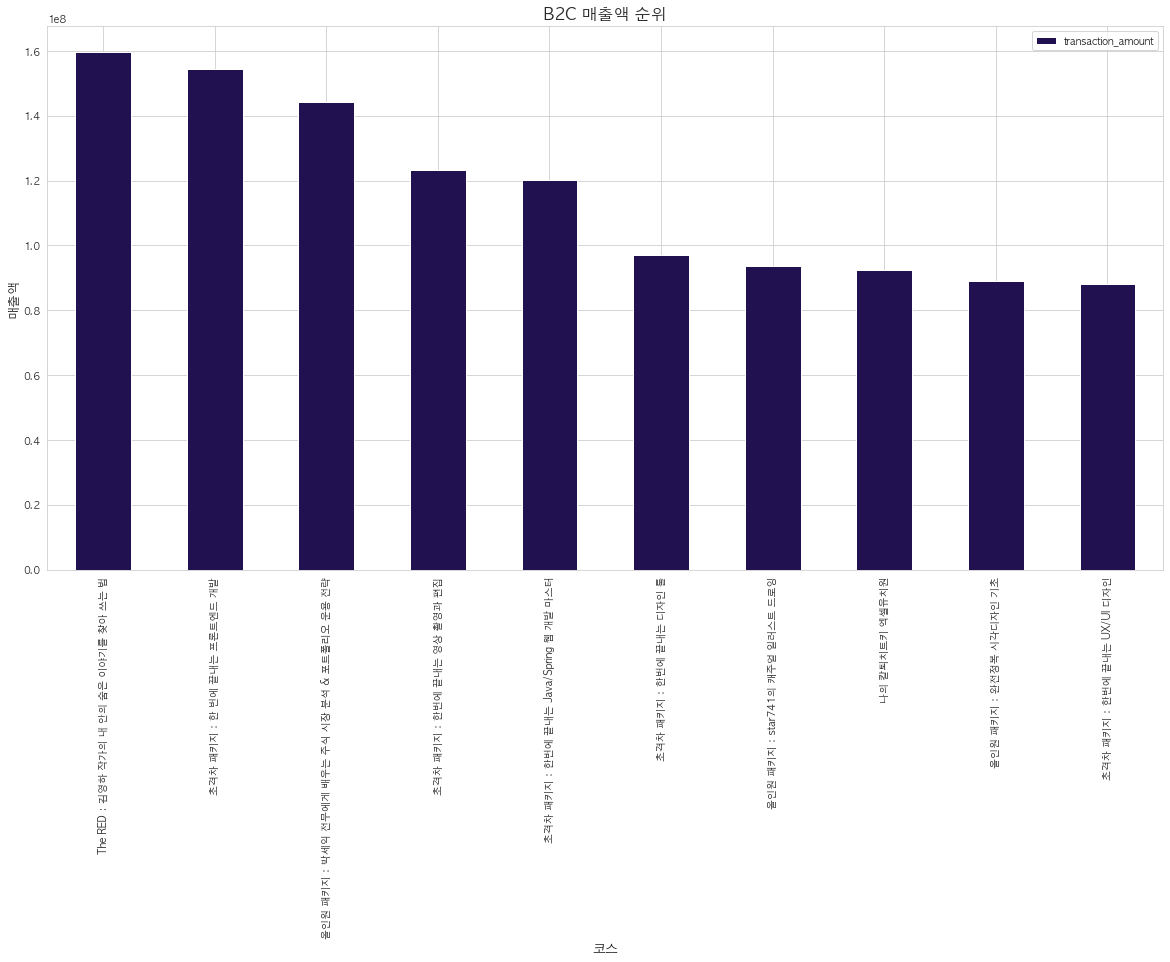

In [75]:
# 매출의 80% 차지하는 코스의 개별 매출액

rev_rank_by_course = data1_pay_completed.pivot_table(index='course_title', values='transaction_amount', aggfunc='sum',
                      sort=True).sort_values(by='transaction_amount', ascending=False)
plot_bar(rev_rank_by_course[:10], 'B2C 매출액 순위', '코스', '매출액')

In [47]:
# 매출의 80%를 차지하는 코스 수, B2C매출 80% = 160개/590개
rev_rank_by_course[:160]['transaction_amount'].sum() / rev_rank_by_course['transaction_amount'].sum()

# B2C매출 3천만원 이상 코스의 매출 비중, 53.39%
rev_rank_by_course[rev_rank_by_course['transaction_amount'] > 3000*10000][
    'transaction_amount'].sum() / rev_rank_by_course['transaction_amount'].sum()

0.5339172789016089

In [48]:
# (rev_rank_by_course[rev_rank_by_course['transaction_amount'] > 3000*10000]['transaction_amount']-(3000*10000)).sum()
# (rev_rank_by_course[rev_rank_by_course[
#     'transaction_amount'] <= 3000*10000]['transaction_amount']-(3000*10000)).sum()

In [49]:
# 'The RED' 포맷인 코스의 매출 분석

# data1_pay_completed[data1_pay_completed['format'] == 'RED'].groupby('course_title').sum()['transaction_amount'].sort_values(ascending=False)
data1_pay_completed[data1_pay_completed['format'] == 'RED'].pivot_table(
    index=['course_title', 'marketing_start_at'], values='transaction_amount', aggfunc='sum').sort_values(
    by='transaction_amount', ascending=False)

transaction_amount
course_title                                       marketing_start_at                     
The RED : 김영하 작가의 내 안의 숨은 이야기를 찾아 쓰는 법             2021-06-18 17:00:00           159686500
The RED : 칼만필터를 활용한 자율주행 센서퓨전 기술 구현 by 조형기         2021-07-02 00:00:00            31085100
The RED : 현실 세상의 TDD by 이규원                        2021-02-08 00:00:00            29913500
The RED : 비즈니스 성공을 위한 Java/Spring 기반 서비스 개발과 MS... 2021-06-29 00:00:00            26241000
The RED : 탑 아티스트가 선택한 디렉터 : 권오준이 알려주는 영상 연출의 모든 것  2021-07-13 00:00:00            24335200
The RED : 지브리 스튜디오 제작국장에게 듣는 스토리텔링 기획법             2020-11-04 00:00:00            23540000
The RED : 개발자로 살아남기 : 30년을 주도하는 9가지 필수 기술 by 박종천   2021-05-12 00:00:00            16030100
The RED : 백발의 개발자를 꿈꾸며 : 코드리뷰, 레거시와 TDD by 백명석,... 2021-07-09 00:00:00            15005900
The RED : 검색엔진 구축을 위한 Elasticsearch 마스터 클래스 by 정호욱 2021-09-06 00:00:00            14534000
The RED : 견고한 UI 설계를 위한 마크업 가이드 by 정찬명             2021-07-01 00:00:00            14455000
THE RED : 광고인 박웅현과 크리에이티브                          2021-03-19 00:00:00            13719000
The RED : 블리자드 라이팅 아티스트 : 이호성의 언리얼 엔진 라이팅          2021-09-13 00:00:00            13258000
The RED : 조은의 프론트엔드 실무 가이드 : 요구사항 분석과 적정 기술        2021-08-09 00:00:00            12135700
The RED : 데이터 사이언티스트 하용호                           2020-08-26 00:00:00            11981000
The RED : Hadoop & Spark 아키텍처 딥다이브                 2021-09-13 00:00:00            10763600
The RED : 김민태                                      2020-10-16 00:00:00            10630500
The RED : 카카오페이지 기술전략이사 윤진석                        2020-12-30 00:00:00             9819000
The RED : 1조 기업 가치를 만들어 낸 경영 원칙 by 신현성             2020-10-23 00:00:00             9756500
The RED : 픽사 라이팅 아티스트에게 배우는 빛과 색의 비주얼 스토리텔링 by 이민형 2021-08-23 00:00:00             9723800
The RED : 최고제품책임자(CPO) 윤희경                         2020-09-04 00:00:00             8460500
The RED : 프론트엔드 개발자 김태곤                            2020-09-11 00:00:00             8075000
The RED : 현실 데이터를 활용한 추천시스템 구현 A to Z by 번개장터 C... 2021-09-06 00:00:00             6201200
The RED : 고객 경험을 개선하는 A/B테스트 기반 모바일 앱 개발 by 이승민    2021-08-30 00:00:00             2663400

In [50]:
data1_pay_completed[data1_pay_completed['format'] == 'RED'].pivot_table(
    index=['course_title', 'marketing_start_at'], values='transaction_amount', aggfunc='sum').sort_values(
    by='marketing_start_at', ascending=False)

transaction_amount
course_title                                       marketing_start_at                     
The RED : 블리자드 라이팅 아티스트 : 이호성의 언리얼 엔진 라이팅          2021-09-13 00:00:00            13258000
The RED : Hadoop & Spark 아키텍처 딥다이브                 2021-09-13 00:00:00            10763600
The RED : 검색엔진 구축을 위한 Elasticsearch 마스터 클래스 by 정호욱 2021-09-06 00:00:00            14534000
The RED : 현실 데이터를 활용한 추천시스템 구현 A to Z by 번개장터 C... 2021-09-06 00:00:00             6201200
The RED : 고객 경험을 개선하는 A/B테스트 기반 모바일 앱 개발 by 이승민    2021-08-30 00:00:00             2663400
The RED : 픽사 라이팅 아티스트에게 배우는 빛과 색의 비주얼 스토리텔링 by 이민형 2021-08-23 00:00:00             9723800
The RED : 조은의 프론트엔드 실무 가이드 : 요구사항 분석과 적정 기술        2021-08-09 00:00:00            12135700
The RED : 탑 아티스트가 선택한 디렉터 : 권오준이 알려주는 영상 연출의 모든 것  2021-07-13 00:00:00            24335200
The RED : 백발의 개발자를 꿈꾸며 : 코드리뷰, 레거시와 TDD by 백명석,... 2021-07-09 00:00:00            15005900
The RED : 칼만필터를 활용한 자율주행 센서퓨전 기술 구현 by 조형기         2021-07-02 00:00:00            31085100
The RED : 견고한 UI 설계를 위한 마크업 가이드 by 정찬명             2021-07-01 00:00:00            14455000
The RED : 비즈니스 성공을 위한 Java/Spring 기반 서비스 개발과 MS... 2021-06-29 00:00:00            26241000
The RED : 김영하 작가의 내 안의 숨은 이야기를 찾아 쓰는 법             2021-06-18 17:00:00           159686500
The RED : 개발자로 살아남기 : 30년을 주도하는 9가지 필수 기술 by 박종천   2021-05-12 00:00:00            16030100
THE RED : 광고인 박웅현과 크리에이티브                          2021-03-19 00:00:00            13719000
The RED : 현실 세상의 TDD by 이규원                        2021-02-08 00:00:00            29913500
The RED : 카카오페이지 기술전략이사 윤진석                        2020-12-30 00:00:00             9819000
The RED : 지브리 스튜디오 제작국장에게 듣는 스토리텔링 기획법             2020-11-04 00:00:00            23540000
The RED : 1조 기업 가치를 만들어 낸 경영 원칙 by 신현성             2020-10-23 00:00:00             9756500
The RED : 김민태                                      2020-10-16 00:00:00            10630500
The RED : 프론트엔드 개발자 김태곤                            2020-09-11 00:00:00             8075000
The RED : 최고제품책임자(CPO) 윤희경                         2020-09-04 00:00:00             8460500
The RED : 데이터 사이언티스트 하용호                           2020-08-26 00:00:00            11981000

In [51]:
# 삭제할 코드
# data1[data1['course_title'].str.contains('하석')]

#### B2C 매출 80% format의 코스별 매출액

#### B2C 매출 80% category_title 의 코스별 매출액

#### B2C marketing_start_at 부터 데이터 마지막 날짜 까지 각 코스의 판매기간 동안 일평균 매출금액에 대한 플롯

#### B2C 코스별 주문완료율(Order Completed / Order ALL count) (Sort = descending)

#### B2C 코스별 구매전환율(Payment Completed / Payment ALL count ) (Sort = descending)

#### B2C 코스별 환불율 (Payment Completed / Refund Completed) (Sort = descending)

### 할인쿠폰 제공이 매출에 미치는 상관관계 히트맵 분석
- [ ] B2C 결제완료 중에서 카테고리별 쿠폰할인 적용율
- [ ] 우수고객과 유사한 고객군을 발굴
- [ ] 잠재 고객 데이터를 활용하여 추가 기대 매출 예측
- [ ] 매출을 높일 수 있는 요소를 찾아 마케팅 전략 제안

#### B2C 결제완료 중에서 카테고리별 쿠폰할인 적용율

#### 우수고객과 유사한 고객군을 발굴

#### 잠재 고객 데이터를 활용하여 추가 기대 매출 예측

#### 매출을 높이기 위한 마케팅 전략 제안